# Data Cleaning and Exploration
### Jay Woo and Casey Alvarado

We explored data about sexual assault cases committed by high-ranking Roman Catholic officals in the USA. In this notebook, we wrote about our initial findings from the dataset.

In [2]:
# Imports
import pandas 
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
import vincent
import numpy as np
%matplotlib inline

/home/casey/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


Some of the features are self-explanatory (name, notes, source). The other features are outlined below:

* Ord - year when the official was ordained
* T - type (P = Priest, B = Brother, S = Seminarian, D = Deacon, N = Nun)
* D/O - diocesan/order employee
* Diocese - primary diocese in which the individual worked

In [3]:
df = pandas.read_csv("data.csv")
df.head()

,Last,First,Ord,T,Status,D/O,Notes,Diocese,Source/Assignments
0,Abaya,Rubin,NaN,P,Accused,Diocesan,One of seven priests named as defendants in ...,"Los Angeles, CA",Source:United Press International 02.08.84; U...
1,Abdon,Andrew,NaN,B,Settled,Bros Christian School,"In separate 1995 lawsuits, 2 brothers and anot...","Santa Fe, NM",Source:Obituary and Assignments 08.17.77;Orti...
2,Abercrombie,Leonard A.,1946,P,Accused,Diocesan,"Letter 7/93 to Pope JP II, Stafford, and Mahon...","Denver, CO",Source:LA Archdiocesan Report 2.17.04 page 3;M...
3,Abeywickrema,Lionel Augustine,1951,P,Accused,Diocesan,"Abeywickrema, originally from Sri Lanka, was a...","Santa Fe, NM",Source:Roswell Daily Record 7.1.93;The New Mex...
4,Abrams,John L.,< 1950,P,Accused,Diocesan,"Some time after 2002 Abrams' ""victims"" report...","Brooklyn, NY",Source:Statement by Diocese of Brooklyn 11.08...


# Data Cleaning

We looked at each of the individual columns and noticed that the 'D/O' column (diocese/order) was particularly messy. For instance, 'Diocesan' is spelled wrong multiple times in the dataset. So, what we did was we manually created a dictionary that auto-corrects all of the entries in the data.

In [4]:
# Some of the data in the D/O feature
sorted(df['D/O'].unique())[73:79]

['Dicoesan', 'Diocesan', 'Diocesan.', 'Diocese', 'Diocesen', 'Dioscean']

In [5]:
# Imports our home-made dictionary and auto-corrects the data
from ord_dict import *

def update_d_o(data):
    if data in corrected_d_o:
        return corrected_d_o[data]
    else:
        return data
    
df['D/O'] = df['D/O'].apply(update_d_o)

sorted(df['D/O'].unique())[42:46]  # Much, much better

['De La Salle Christian Brothers',
 'Diocesan',
 'Discalced Carmelite Friars',
 'Divine Word Missionaries']

The 'Ord' column was also particularly messy. Some of the years have '<' or '>' prepended to them and others are simply '?', indicating uncertainty in the dataset. So, we went through the data and only pulled out the digits from the column. We put all of the modifiers (<, >, ?, or = if there is no modifier) into a new column called 'Ord_Mod.'

In [6]:
def get_modifiers(ord_data):
    #input: data column 
    #output: item or empty string 
    
    #split data on these weird characters we noticed 
    splitted = str(ord_data).split('\xc2\xa0')
    
    #if the item in the splitted array is a digit, return the number. 
    #else, forget the weird symbols and return an empty string 
    for item in splitted:
        if not item.isdigit():
            return item
    return '='

# Pulls modifiers
df.Ord = df.Ord.fillna(0)
df["Ord_Mod"] = df.Ord.apply(get_modifiers)
df.Ord_Mod[df.Ord_Mod == 'nan'] = ''

# Replaces all of the Ord data with integers
for o in range(len(df.Ord)):
    o_list = str(df.Ord[o]).split('\xc2\xa0')
    for item in o_list: 
        if(item.isdigit()): 
            df.Ord[o] = int(item)

df.head()

,Last,First,Ord,T,Status,D/O,Notes,Diocese,Source/Assignments,Ord_Mod
0,Abaya,Rubin,0,P,Accused,Diocesan,One of seven priests named as defendants in ...,"Los Angeles, CA",Source:United Press International 02.08.84; U...,=
1,Abdon,Andrew,0,B,Settled,Brothers of the Christian Schools,"In separate 1995 lawsuits, 2 brothers and anot...","Santa Fe, NM",Source:Obituary and Assignments 08.17.77;Orti...,=
2,Abercrombie,Leonard A.,1946,P,Accused,Diocesan,"Letter 7/93 to Pope JP II, Stafford, and Mahon...","Denver, CO",Source:LA Archdiocesan Report 2.17.04 page 3;M...,=
3,Abeywickrema,Lionel Augustine,1951,P,Accused,Diocesan,"Abeywickrema, originally from Sri Lanka, was a...","Santa Fe, NM",Source:Roswell Daily Record 7.1.93;The New Mex...,=
4,Abrams,John L.,1950,P,Accused,Diocesan,"Some time after 2002 Abrams' ""victims"" report...","Brooklyn, NY",Source:Statement by Diocese of Brooklyn 11.08...,<


Finally, we made sure we weren't missing any values in any of the other columns.

In [7]:
''' Fills the rest of the missing values in the data with defaults '''
def clean_data(data):
    data["First"] = data["First"].fillna("")   
    data["Status"] = data["Status"].fillna("Unknown")
    data["D/O"] = data["D/O"].fillna("Unknown")
    data["Notes"] = data["Notes"].fillna("")
    data[data["Diocese"] == "none"] = "Unknown, UNK"
    
    # Removes punctuation and lowercases the 'Status' column ("convicted" = "Convicted", "sued" = "sued.")
    data["Status"] = data["Status"].str.lower()
    data["Status"] = data["Status"].str.strip(".")
    
    return data 

df = clean_data(df)
df.head()

,Last,First,Ord,T,Status,D/O,Notes,Diocese,Source/Assignments,Ord_Mod
0,Abaya,Rubin,0,P,accused,Diocesan,One of seven priests named as defendants in ...,"Los Angeles, CA",Source:United Press International 02.08.84; U...,=
1,Abdon,Andrew,0,B,settled,Brothers of the Christian Schools,"In separate 1995 lawsuits, 2 brothers and anot...","Santa Fe, NM",Source:Obituary and Assignments 08.17.77;Orti...,=
2,Abercrombie,Leonard A.,1946,P,accused,Diocesan,"Letter 7/93 to Pope JP II, Stafford, and Mahon...","Denver, CO",Source:LA Archdiocesan Report 2.17.04 page 3;M...,=
3,Abeywickrema,Lionel Augustine,1951,P,accused,Diocesan,"Abeywickrema, originally from Sri Lanka, was a...","Santa Fe, NM",Source:Roswell Daily Record 7.1.93;The New Mex...,=
4,Abrams,John L.,1950,P,accused,Diocesan,"Some time after 2002 Abrams' ""victims"" report...","Brooklyn, NY",Source:Statement by Diocese of Brooklyn 11.08...,<


In [8]:
df.to_csv('cleanedData.csv')

# Number of Catholics By State

We wanted to count how many cases occurred in each state, and in order to normalize these counts, we looked at each state's population as well as the percentage the people reported that they were Catholic. We hoped to see a correlation between the percentage of Catholics and the normalized number of sexual assault cases by state.

In [9]:
# "Religious fervor" data
rf_df = pandas.read_csv('state_data.csv')
rf_df.head()

,State,Abbrev,Population,Percent_Catholic
0,Alabama,AL,4779736,0.07
1,Alaska,AK,710231,0.16
2,Arizona,AZ,6392017,0.21
3,Arkansas,AR,2915918,0.08
4,California,CA,37253956,0.28


For each individual in the data, we extracted the state of his/her diocese from the 'Diocese' column and counted how many cases occurred in each state. We then normalized each of these counts by the population of the state (as of 2015).

In [29]:
# Dictionary mapping state abbreviations to state names
from state_dict import *

# Stores counts by state
states = {};

# Grabs the state abbreviations from 'Diocese' data
for l in df.Diocese:
    state = l.split(", ")[1]
    if state in state_dict:
        state = state_dict[state]
    else:
        continue
    
    if state in states.keys():
        states[state]+=1; 
    else: 
        states[state] =1; 

# Maps the dictionary to the pandas data frame
rf_df['Count'] = rf_df['State'].map(states)
rf_df['NormalizedCount'] = rf_df['Count']/rf_df['Population']
rf_df.head()

/home/casey/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,State,Abbrev,Population,Percent_Catholic,Count,NormalizedCount
0,Alabama,AL,4779736,0.07,14,2.929032e-06
1,Alaska,AK,710231,0.16,54,7.603160e-05
2,Arizona,AZ,6392017,0.21,61,9.543154e-06
3,Arkansas,AR,2915918,0.08,2,6.858903e-07
4,California,CA,37253956,0.28,503,1.350192e-05


# Bar plot of states with highest cases

In [11]:
states

{'Alabama': 14,
 'Alaska': 54,
 'Arizona': 61,
 'Arkansas': 2,
 'California': 503,
 'Colorado': 29,
 'Connecticut': 90,
 'Delaware': 38,
 'District of Columbia': 26,
 'Florida': 101,
 'Georgia': 8,
 'Hawaii': 18,
 'Idaho': 7,
 'Illinois': 238,
 'Indiana': 47,
 'Iowa': 82,
 'Kansas': 21,
 'Kentucky': 99,
 'Louisiana': 75,
 'Maine': 49,
 'Maryland': 69,
 'Massachusetts': 376,
 'Michigan': 112,
 'Minnesota': 187,
 'Mississippi': 8,
 'Missouri': 108,
 'Montana': 50,
 'Nebraska': 15,
 'Nevada': 6,
 'New Hampshire': 90,
 'New Jersey': 148,
 'New Mexico': 71,
 'New York': 297,
 'North Carolina': 14,
 'North Dakota': 13,
 'Ohio': 137,
 'Oklahoma': 8,
 'Oregon': 93,
 'Pennsylvania': 278,
 'Rhode Island': 35,
 'South Carolina': 12,
 'South Dakota': 32,
 'Tennessee': 17,
 'Texas': 127,
 'Utah': 4,
 'Vermont': 15,
 'Virginia': 22,
 'Washington': 91,
 'West Virginia': 6,
 'Wisconsin': 121,
 'Wyoming': 2}

/home/casey/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


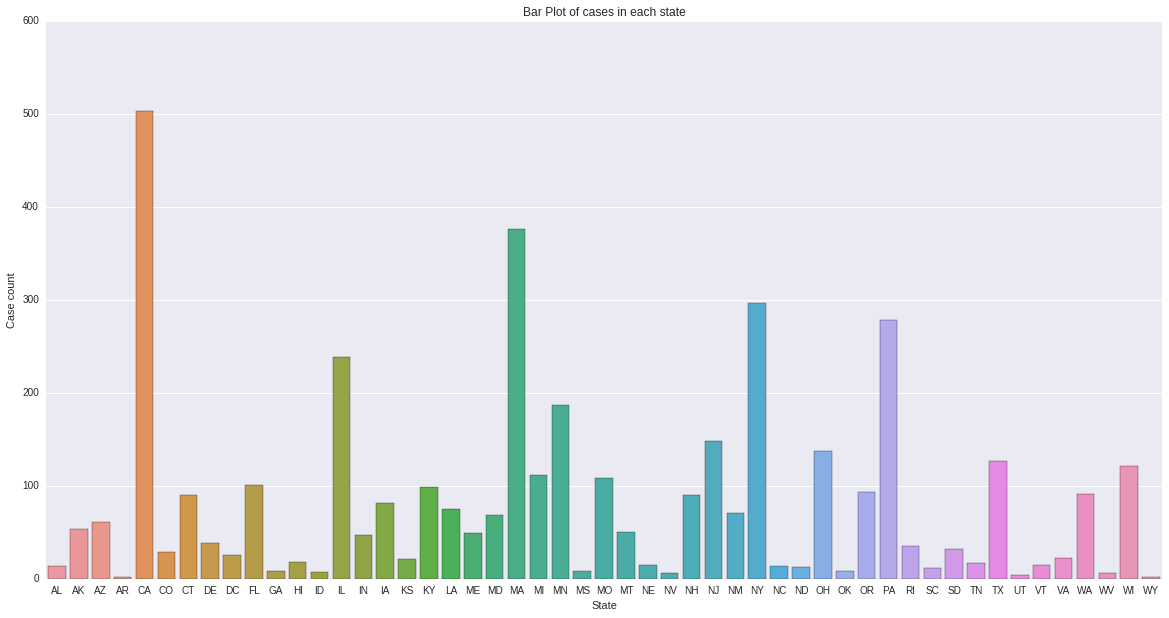

In [12]:
plt.figure(figsize=(20,10))
ax = sns.barplot(x=rf_df.Abbrev, y=rf_df.Count)
plt.xlabel('State')
plt.ylabel('Case count')
plt.title('Bar Plot of cases in each state')

The bar plot shows that CA, MA, and NY had the most cases, out of all of the states. This, of course, might be because they are some of the largest states in the US. We tried to normalize, in column "NormalizedCount". We will plot that data in a scatter plot, but we wanted to visualize all of the cases in each state.

# Correlation between catholics in each state and cases 

We discovered a moderate correlation between the percentage of Catholics in each state and the normalized counts of sexual assault cases. 

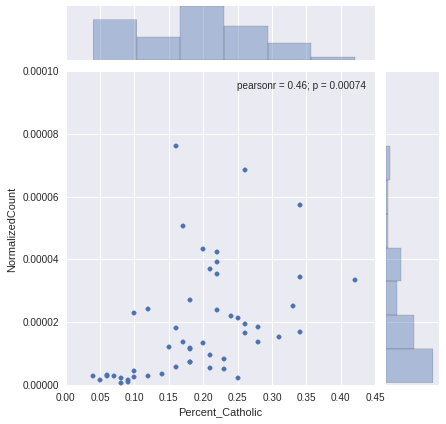

In [13]:
sns.jointplot(x='Percent_Catholic', y='NormalizedCount', data=rf_df)
plt.ylim([0, 1e-4])

ax.set_xlabel('Percent Catholic', fontsize=14)
ax.set_ylabel('Normalized Count', fontsize=14)

ax.grid(True)

plt.show()

In [14]:
print 'Pearson Correlation (full data)'
print scipy.stats.pearsonr(rf_df['Percent_Catholic'], rf_df['NormalizedCount'])[0]

Pearson Correlation (full data)
0.457408208838


The Pearson correlation for the scatter plot showing the percent catholic of a state and the normalized number of sexual assault cases per state was positive and high, **0.46**. 
We also found that there is a stronger correlation for states that have a population larger than 3,000,000. This, below, produced a Pearson correlation of **0.59**

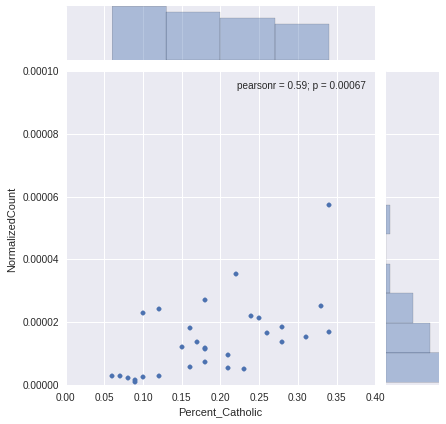

In [15]:
rf_df_trimmed = rf_df[rf_df['Population'] > 3000000]
sns.jointplot(x='Percent_Catholic', y='NormalizedCount', data=rf_df_trimmed)

plt.ylim([0, 1e-4])
ax.set_xlabel('Percent Catholic', fontsize=14)
ax.set_ylabel('Normalized Count', fontsize=14)

ax.grid(True)
plt.show()

In [16]:
print 'Pearson Correlation (pop > 3,000,000)'
print scipy.stats.pearsonr(rf_df_trimmed['Percent_Catholic'], rf_df_trimmed['NormalizedCount'])[0]

Pearson Correlation (pop > 3,000,000)
0.58610601131


As seen above, the Pearson correlation for large states is both positive and large. These scatter plots really motivated us and make us feel so passionately about why we are doing this project. Therefore, this or something similar to this is the visualization we want to show. We want to show this trend and strong correlation.

# exploring status of charges. 


In [18]:
df.Status.unique()

array(['accused', 'settled', 'convicted', 'sued', 'charged', 'arrested',
       'charges dropped', 'acquitted', 'none', 'indicted', 'cleared',
       'suez', 'unknown, unk', 'reinstated', 'police report',
       'suit withdrawn', 'not guilty', 'unknown', 'sentenced',
       "ret'd to duty"], dtype=object)

In [22]:
df.Status.value_counts()

accused            1782
sued               1297
convicted           449
settled             428
arrested             70
charged              28
none                 15
indicted             15
acquitted            13
reinstated            9
cleared               7
unknown, unk          7
unknown               5
sentenced             3
suit withdrawn        2
charges dropped       2
police report         2
not guilty            1
ret'd to duty         1
suez                  1
Name: Status, dtype: int64

In [28]:
new_statuses = {"none": "accused",
                "ret'd to duty": "cleared",
                "charges dropped": "cleared",
                "acquitted": "cleared",
                "suit withdrawn": "cleared",
                "reinstated": "cleared",
                "settled": "incriminated",
                "police report": "incriminated",
                "sued": "incriminated",
                "suez": "incriminated",
                "convicted": "incriminated",
                "arrested": "incriminated",
                "indicted": "incriminated",
                "unknown, unk": "unknown"}

def change_statuses(data):
    if data in new_statuses:
        return new_statuses[data]
    else:
        return data
    
df.Status.apply(change_statuses).value_counts()

incriminated    2262
accused         1797
cleared           34
charged           28
unknown           12
sentenced          3
not guilty         1
Name: Status, dtype: int64

In [ ]:
charges = {}

for row in df:
    if state in charges.keys(): 
        if (df.Status == "none"       
    else: 
        

In [ ]:
charges = {}

# Grabs the state abbreviations from 'Diocese' data
for l in df.Diocese:
    state = l.split(", ")[1]
    if state in state_dict:
        state = state_dict[state]
    else:
        continue
    
    if state in states.keys():
        list_val = charges[states];
        if (df.Status == "none"): 
            
            
    else: 
        states[state] =1; 